In [1]:
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
from base import PromptAttn, p_svm_solver, w_svm_solver

In [2]:
tight_converge = True
n = 3
T = 2
d = 2
ITN = 1000


ps = np.zeros((ITN, d))
ws = np.zeros((ITN, d))
p_probs = np.zeros((ITN))
v_probs = np.zeros((ITN))

def data_generator():
    v = torch.tensor([0.,1.])
    Y = torch.tensor([1,-1,1])
    if tight_converge:
        X = torch.tensor([
            [[0,0],[1,1]],
            [[0,-0],[1,-1]],
            [[0,-0],[0.5,1]],
        ])
    else:
        X = torch.tensor([
            [[0,0],[1,1]],
            [[0,-0],[1,-1]],
            [[0,-0],[0.5,1.5]],
        ])
    return X, Y, v

In [3]:
X, Y, v = data_generator()
model = PromptAttn(d)
model.prompt.data = torch.tensor([0,-1.])
model.w.data = torch.tensor([-1.,0])
optimizer = torch.optim.SGD([model.w, model.prompt], lr=0.1)
for it in range(ITN):
    ps[it] = model.prompt.detach().numpy()
    ws[it] = model.w.detach().numpy()
    optimizer.zero_grad()    
    out = model(X)
    loss = torch.log(1+torch.exp(-Y*out))
    p_probs[it] = model.attention.detach().numpy()[:,1].mean()
    v_probs[it] = (1/(1+torch.exp(-Y*out))).mean()
    loss = loss.mean()
    loss.backward()
    model.prompt.grad /= (model.prompt.grad.norm()+0.0000000000000000001)
    model.w.grad /= (model.w.grad.norm()+0.000000001)
    optimizer.step()

     pcost       dcost       gap    pres   dres
 0:  2.8989e-01  6.9050e-01  1e+00  1e+00  3e-16
 1:  5.3765e-01  8.3823e-01  8e-02  3e-01  2e-16
 2:  9.5330e-01  9.4285e-01  1e-02  1e-16  2e-15
 3:  9.4453e-01  9.4443e-01  1e-04  1e-16  4e-16
 4:  9.4445e-01  9.4444e-01  1e-06  1e-16  3e-16
 5:  9.4444e-01  9.4444e-01  1e-08  2e-16  3e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.9992e-01  1.1749e+00  5e+00  2e+00  3e+00
 1:  9.9885e-01  2.6360e-01  7e-01  1e-16  6e-16
 2:  5.2123e-01  4.7549e-01  5e-02  2e-16  2e-16
 3:  5.0035e-01  4.9976e-01  6e-04  2e-16  5e-16
 4:  5.0000e-01  5.0000e-01  6e-06  8e-17  3e-16
 5:  5.0000e-01  5.0000e-01  6e-08  1e-16  4e-16
Optimal solution found.


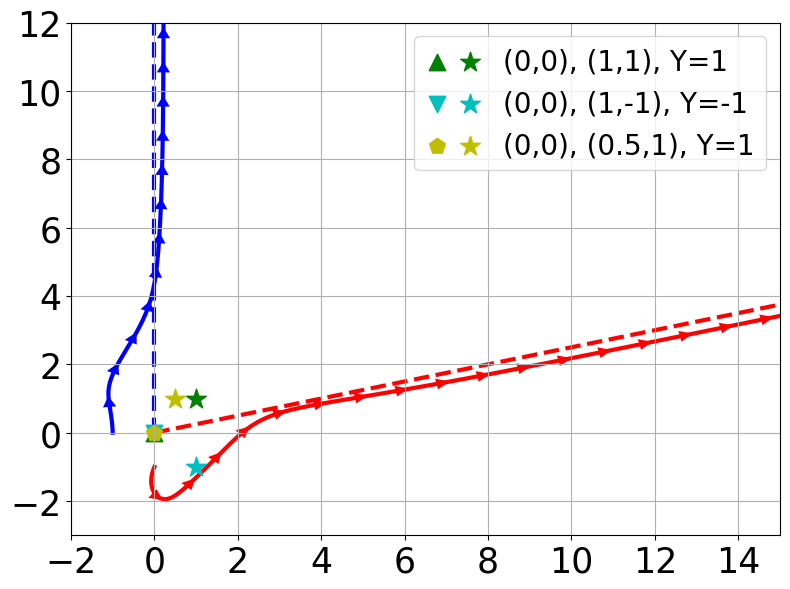

In [4]:
sol_opt, _ = p_svm_solver(X, torch.diag(torch.ones(d)), torch.tensor([1,1,1]))
sol_relax, _ = p_svm_solver(X, torch.diag(torch.ones(d)), torch.tensor([1,1,1]), [2])
sol_v = w_svm_solver(X, Y, torch.tensor([1,1,1]))

plt.figure(figsize=(8,6))
s11 = plt.scatter(X[0,0,0],X[0,0,1],marker='^',color='g',s=140, zorder=1)
s12 = plt.scatter(X[0,1,0],X[0,1,1],marker='*',color='g',s=220, zorder=1)
s21 = plt.scatter(X[1,0,0],X[1,0,1],marker='v',color='c',s=140, zorder=1)
s22 = plt.scatter(X[1,1,0],X[1,1,1],marker='*',color='c',s=220, zorder=1)
s31 = plt.scatter(X[1,0,0],X[1,0,1],marker='p',color='y',s=140, zorder=1)
s32 = plt.scatter(X[2,1,0],X[2,1,1],marker='*',color='y',s=220, zorder=1)

x = np.arange(0,20)
if tight_converge:
    plt.plot(x,sol_opt[1]/sol_opt[0]*x, '--', color='red', linewidth=3, zorder=-1)
else:
    plt.plot(x,sol_relax[1]/sol_relax[0]*x, '--', color='red', linewidth=3, zorder=-1)
    plt.plot(x,sol_opt[1]/sol_opt[0]*x, '--', color='gray', linewidth=3, zorder=-1)
plt.plot(x,sol_v[1]/(sol_v[0]+0.0000001)*x, 'b--', linewidth=3, zorder=-1)

THRED = 200
plt.plot(ps[:THRED,0], ps[:THRED,1], linewidth=3, linestyle='-', color='r', zorder=-1)
plt.plot(ws[:THRED,0], ws[:THRED,1], linewidth=3, linestyle='-', color='b', zorder=-1)
for i in range(THRED):
    if (i+1) % 10 == 0:
        plt.arrow((ps[i,0]), (ps[i,1]), (ps[i+1,0]-ps[i,0]), (ps[i+1,1]-ps[i,1]), length_includes_head=True,head_width=0.2, head_length=0.2, color='red', linewidth=2)
        plt.arrow((ws[i,0]), (ws[i,1]), (ws[i+1,0]-ws[i,0]), (ws[i+1,1]-ws[i,1]), length_includes_head=True,head_width=0.2, head_length=0.2, color='blue', linewidth=2)


labels = [
    rf'(0,0), (1,1), Y={Y[0]}',
    rf'(0,0), (1,-1), Y={Y[1]}', 
    rf'(0,0), (0.5,1), Y={Y[2]}' if tight_converge else rf'(0,0), (0.5,1.5), Y={Y[2]}'
]
plt.legend([(s11,s12), (s21,s22), (s31,s32)], labels, fontsize=20, loc='upper right', handler_map = {tuple: matplotlib.legend_handler.HandlerTuple(None)})

plt.xlim([-2,15])
plt.ylim([-3,12])
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.grid()
plt.tight_layout()
plt.show()

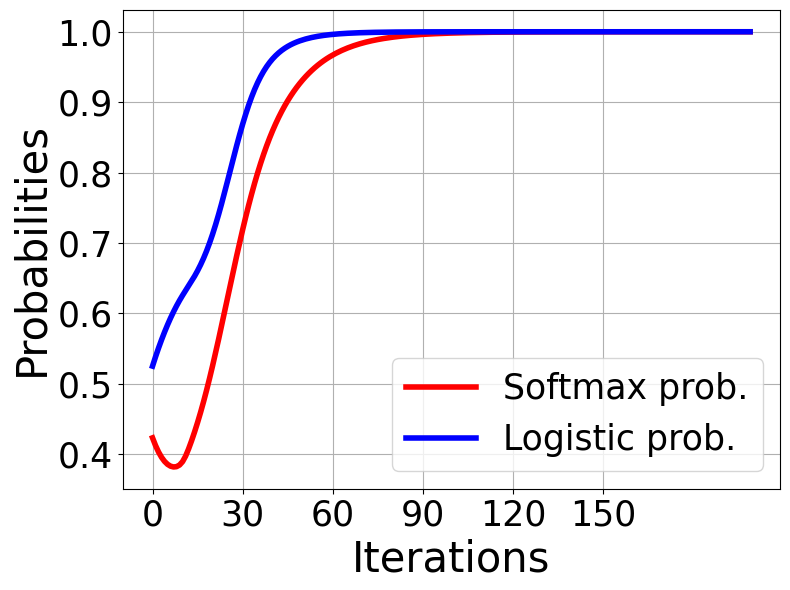

In [5]:
plt.figure(figsize=(8,6))
THRED = 200
plt.plot(p_probs[:THRED], linewidth=4, linestyle='-', color='r')
plt.plot(v_probs[:THRED], linewidth=4, linestyle='-', color='b')

plt.xticks([0,30,60,90,120,150],fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Iterations', fontsize=30)
plt.ylabel(r'Probabilities', fontsize=30)
plt.legend(['Softmax prob.', 'Logistic prob.'], fontsize=25)
plt.grid()
plt.tight_layout()
plt.show()